In [30]:
import os
import sklearn
import numpy as np
import matplotlib.pyplot as plt

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

from scipy import ndimage

from keras.utils import to_categorical
from keras.datasets import mnist
from keras_preprocessing.image import ImageDataGenerator

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.externals import joblib
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

In [2]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [24]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [25]:
old_shape = x_train.shape
x_train = x_train.reshape(old_shape[0], old_shape[1]*old_shape[2])

old_shape = x_test.shape
x_test = x_test.reshape(old_shape[0], old_shape[1]*old_shape[2])

# Correlation Matrix Before PCA

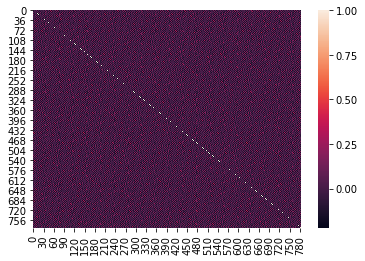

In [28]:
import seaborn as sbs

_shape = x_train.shape

corr_mtx = np.corrcoef(x_train.reshape(_shape[1], _shape[0]))
sbs.heatmap(corr_mtx)
plt.show()

# Applying PCA

In [5]:
pca = PCA(n_components = 28)
x_train_pca = pca.fit(x_train)

x_train = x_train_pca.transform(x_train)

x_test = x_train_pca.transform(x_test)

# Correlation Matrix After PCA

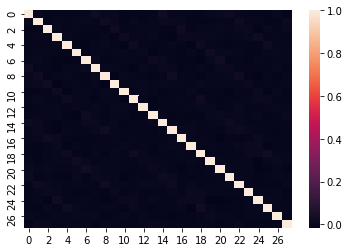

In [22]:
import seaborn as sbs

corr_mtx = np.corrcoef(x_train.reshape(28, 60000))
sbs.heatmap(corr_mtx)
plt.show()

# Random Forest Classifier (100 trees)

In [51]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=4)
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.99      0.99      1135
           2       0.95      0.95      0.95      1032
           3       0.94      0.94      0.94      1010
           4       0.94      0.95      0.94       982
           5       0.94      0.94      0.94       892
           6       0.96      0.98      0.97       958
           7       0.96      0.95      0.95      1028
           8       0.94      0.92      0.93       974
           9       0.93      0.91      0.92      1009

   micro avg       0.95      0.95      0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

0.9524
Confusion matrix, without normalization


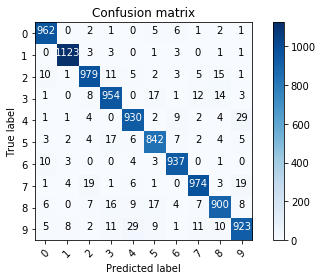

In [52]:
y_pred = rf.predict(x_test)

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

plot_confusion_matrix(confusion_matrix(y_test, y_pred), np.arange(0, 10))

# AdaBoost Classifier (100 trees, max depth 10)

In [57]:
clf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=10),n_estimators = 100)
clf.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=100, random_state=None)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       980
           1       0.99      0.98      0.99      1135
           2       0.96      0.94      0.95      1032
           3       0.94      0.94      0.94      1010
           4       0.94      0.93      0.94       982
           5       0.91      0.93      0.92       892
           6       0.98      0.94      0.96       958
           7       0.97      0.92      0.95      1028
           8       0.88      0.96      0.92       974
           9       0.89      0.93      0.91      1009

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.95      0.94      0.94     10000

0.9445
Confusion matrix, without normalization


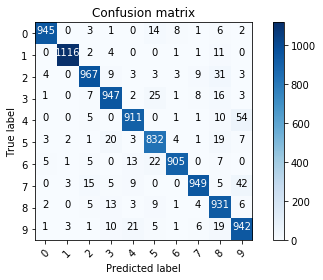

In [58]:
y_pred = clf.predict(x_test)

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

plot_confusion_matrix(confusion_matrix(y_test, y_pred), np.arange(0, 10))

# XGBoost Classifier (150 trees, max depth 10, 30 rounds)

In [139]:
import xgboost as xgb

num_round = 30

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

dtrain = xgb.DMatrix(x_train, label = y_train)
dtest = xgb.DMatrix(x_test, label = y_test)

param = {
         "objective":"multi:softmax",
         "num_class":10,
         "max_depth":10,
         "n_estimators":150
        }

param['nthread'] = 4
param['eval_metric'] = 'merror'

evallist = [(dtest, 'eval'), (dtrain, 'train')]

bst = xgb.train(param, dtrain, num_round, evallist)


[18:44:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 372 extra nodes, 0 pruned nodes, max_depth=10
[18:44:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[18:44:05] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 546 extra nodes, 0 pruned nodes, max_depth=10
[18:44:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 778 extra nodes, 0 pruned nodes, max_depth=10
[18:44:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 678 extra nodes, 0 pruned nodes, max_depth=10
[18:44:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 632 extra nodes, 0 pruned nodes, max_depth=10
[18:44:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 454 extra nodes, 0 pruned nodes, max_depth=10
[18:44:07] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 506 extra nodes, 0 pruned nodes, max_depth=10


[18:44:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 602 extra nodes, 0 pruned nodes, max_depth=10
[18:44:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 512 extra nodes, 0 pruned nodes, max_depth=10
[18:44:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 442 extra nodes, 0 pruned nodes, max_depth=10
[18:44:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 568 extra nodes, 0 pruned nodes, max_depth=10
[18:44:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 640 extra nodes, 0 pruned nodes, max_depth=10
[18:44:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 746 extra nodes, 0 pruned nodes, max_depth=10
[6]	eval-merror:0.0742	train-merror:0.0158
[18:44:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=10
[18:44:24] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 316

[18:44:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 558 extra nodes, 0 pruned nodes, max_depth=10
[18:44:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 528 extra nodes, 0 pruned nodes, max_depth=10
[12]	eval-merror:0.0631	train-merror:0.003733
[18:44:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 338 extra nodes, 0 pruned nodes, max_depth=10
[18:44:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 236 extra nodes, 0 pruned nodes, max_depth=10
[18:44:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 432 extra nodes, 0 pruned nodes, max_depth=10
[18:44:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 492 extra nodes, 0 pruned nodes, max_depth=10
[18:44:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 0 pruned nodes, max_depth=10
[18:44:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 

[18:44:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 226 extra nodes, 0 pruned nodes, max_depth=10
[18:44:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 384 extra nodes, 0 pruned nodes, max_depth=10
[18:44:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 0 pruned nodes, max_depth=10
[18:44:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 306 extra nodes, 0 pruned nodes, max_depth=10
[18:44:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 240 extra nodes, 0 pruned nodes, max_depth=10
[18:44:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 284 extra nodes, 0 pruned nodes, max_depth=10
[18:44:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 336 extra nodes, 0 pruned nodes, max_depth=10
[18:44:55] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 320 extra nodes, 0 pruned nodes, max_depth=10


[18:45:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 222 extra nodes, 0 pruned nodes, max_depth=10
[18:45:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[18:45:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 0 pruned nodes, max_depth=10
[25]	eval-merror:0.0491	train-merror:5e-05
[18:45:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 150 extra nodes, 0 pruned nodes, max_depth=10
[18:45:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=10
[18:45:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=10
[18:45:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 0 pruned nodes, max_depth=10
[18:45:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       980
           1       0.98      0.99      0.99      1135
           2       0.95      0.95      0.95      1032
           3       0.95      0.95      0.95      1010
           4       0.95      0.94      0.95       982
           5       0.93      0.95      0.94       892
           6       0.97      0.97      0.97       958
           7       0.95      0.95      0.95      1028
           8       0.94      0.93      0.93       974
           9       0.93      0.92      0.93      1009

   micro avg       0.95      0.95      0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

0.9524
Confusion matrix, without normalization


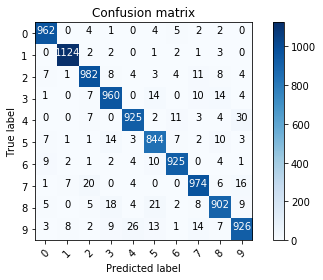

In [140]:
y_pred = bst.predict(dtest)

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

plot_confusion_matrix(confusion_matrix(y_test, y_pred), np.arange(0, 10))

# Naive Bayes Classifier

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       980
           1       0.94      0.94      0.94      1135
           2       0.86      0.83      0.85      1032
           3       0.84      0.84      0.84      1010
           4       0.86      0.87      0.86       982
           5       0.75      0.84      0.79       892
           6       0.91      0.91      0.91       958
           7       0.91      0.85      0.88      1028
           8       0.84      0.83      0.83       974
           9       0.84      0.83      0.84      1009

   micro avg       0.87      0.87      0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

0.8683
Confusion matrix, without normalization


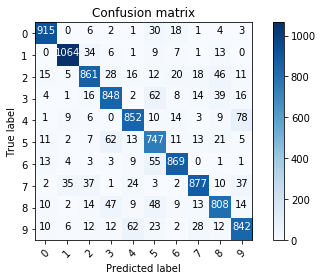

In [113]:
gnb = GaussianNB()
y_pred = gnb.fit(x_train, y_train).predict(x_test)

print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

plot_confusion_matrix(confusion_matrix(y_test, y_pred), np.arange(0, 10))

# Gradient Boosting Classifier

In [ ]:
classf = GradientBoostingClassifier()
classf.fit(x_train, y_train)\
